In [1]:
import os
import copy

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
# Load HGDP
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/HGDP_sub/'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet.hdf5'
metadata_file = 'labels.tsv'
unrelated_sampleid_1000G_path = '/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/1000G_unrelated_samples_set_2504.txt'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

inputs, class_labels, sample, snp_names, class_label_names, metadata_labels = data_loader.load_data_HDGP(data_path, metadata_path, unrelated_sampleid_1000G_path)

Removed 701 related individuals


In [5]:
#np.save('inputs_hgdp', inputs)
#metadata_labels.to_csv('metadata_labels_hgdp')
#pd.DataFrame(sample).to_csv('samples')

In [6]:
def make_palette_label_order_HGDP(metadata_labels):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

In [7]:
pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(metadata_labels)

## Make PCA

In [8]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

In [17]:
# initial phate embedding
phate_operator = phate.PHATE(random_state=42, knn=5, t=10, n_pca=None)
phate_operator.fit(pca_input[:,:100])
phate_emb = phate_operator.transform()

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.79 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.83 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.17 seconds.
  Calculating KMeans...
  Calculated KMeans in 5.22 seconds.
Calculated landmark operator in 6.02 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.19 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.82 seconds.


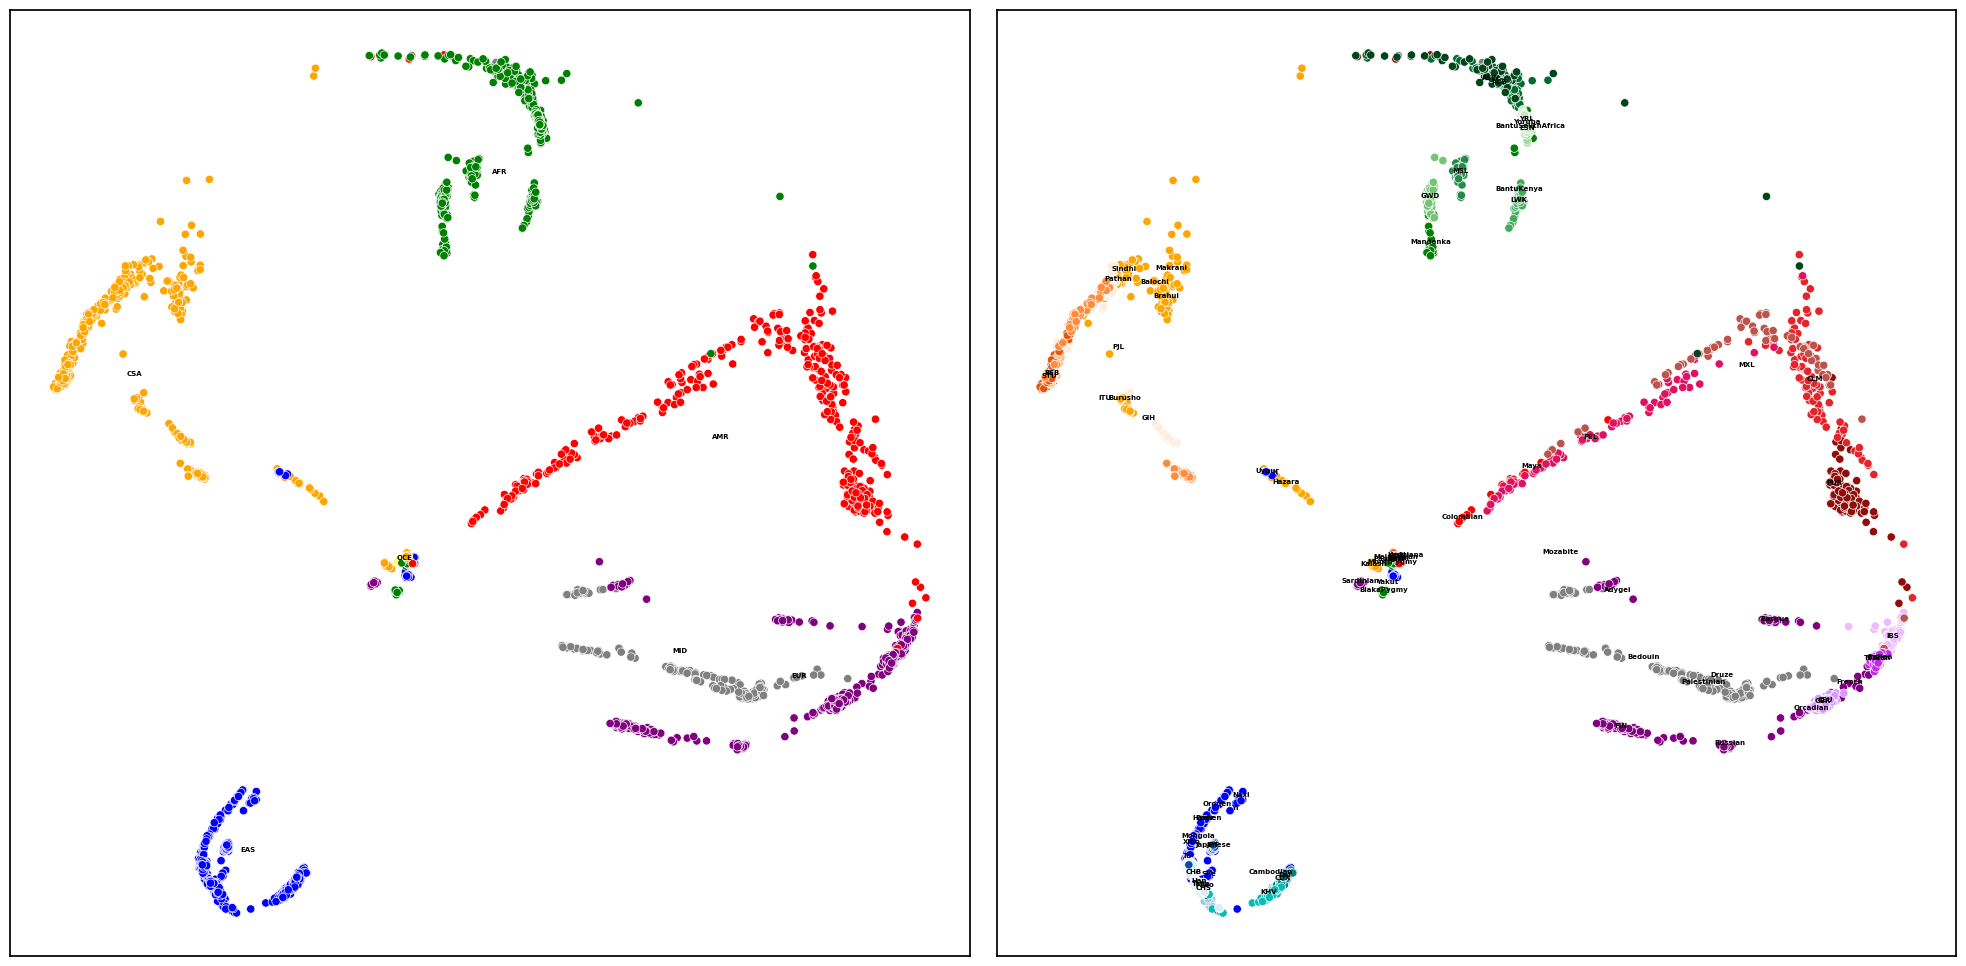

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Superpopulation'].values, 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse,
                         True,
                         ax[0])
plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Population'].values, 
                         None,
                         pop_palette_hgdp_fine,
                         label_order_hgdp_fine,
                         True,
                         ax[1])
plt.tight_layout()

## 3D Phate

In [11]:
# initial phate embedding
phate_operator_3d = phate.PHATE(random_state=42, n_components=3, knn=5, t=10, n_pca=None)
phate_operator_3d.fit(pca_input)
phate_emb_3d = phate_operator_3d.transform()

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.81 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.85 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.18 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.29 seconds.
Calculated landmark operator in 2.10 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.21 seconds.
Calculating metric MDS...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Calculated metric MDS in 13.89 seconds.


In [26]:
# Mimics scprep.plot.rotate_scatter3d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def rotate_scatter3d(emb_3d, 
                     c, 
                     cmap, 
                     figsize, 
                     filename, 
                     label_prefix='', 
                     ticks=True, 
                     show_legend=True):

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    colors = [cmap[x] for x in c]

    # Creating the scatter plot
    sc = ax.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2], 
                    c=colors, 
                    cmap=cmap)

    # Remove the legend if it gets created
    if not show_legend:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    ax.set_xlabel("{} 1".format(label_prefix))
    ax.set_ylabel("{} 2".format(label_prefix))
    ax.set_zlabel("{} 3".format(label_prefix))
    ax.set_title("3D {} Embedding".format(label_prefix))

    if not ticks:
        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    def update(frame):
        ax.view_init(elev=10., azim=frame)
        return fig,

    # Creating the animation
    ani = animation.FuncAnimation(fig, 
                                  update, 
                                  frames=np.arange(0, 360, 2), 
                                  interval=100)

    # Saving the animation
    ani.save(filename, writer='ffmpeg')

    plt.show()

/tmp/ipykernel_252550/3998752721.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2],


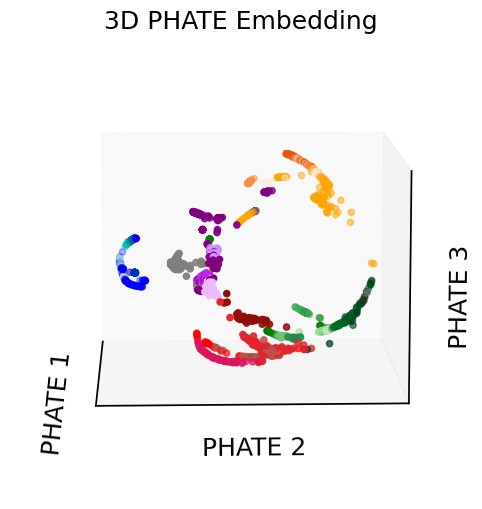

In [27]:
rotate_scatter3d(phate_emb_3d, 
                 c=pd.Categorical(metadata_labels['Population']), 
                 figsize=(8,6),
                 cmap=pop_palette_hgdp_fine,
                 ticks=False, 
                 label_prefix="PHATE",
                 filename='1000G+HGDP_3dPHATE.mp4',
                 show_legend=False)

## Remove Admixed Populations

In [11]:
to_exclude = ['PEL', 'PUR', 'CLM', 'Colombian', 'MXL']
idx_to_keep = (~metadata_labels['Population'].isin(to_exclude)).values

pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs[idx_to_keep])

In [12]:
pop_palette_hgdp_fine_noadmixAMR = copy.deepcopy(pop_palette_hgdp_fine)
for x in to_exclude:
    _ = pop_palette_hgdp_fine_noadmixAMR.pop(x)

label_order_hgdp_fine_noadmixAMR = copy.deepcopy(label_order_hgdp_fine)
for x in to_exclude:
    label_order_hgdp_fine_noadmixAMR.remove(x)

In [13]:
phate_operator = phate.PHATE(random_state=42, knn=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

Running PHATE on 3095 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.67 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.71 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.16 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.28 seconds.
Calculated landmark operator in 3.07 seconds.
Calculating optimal t...
  Automatically selected t = 9
Calculated optimal t in 2.65 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.16 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.71 seconds.


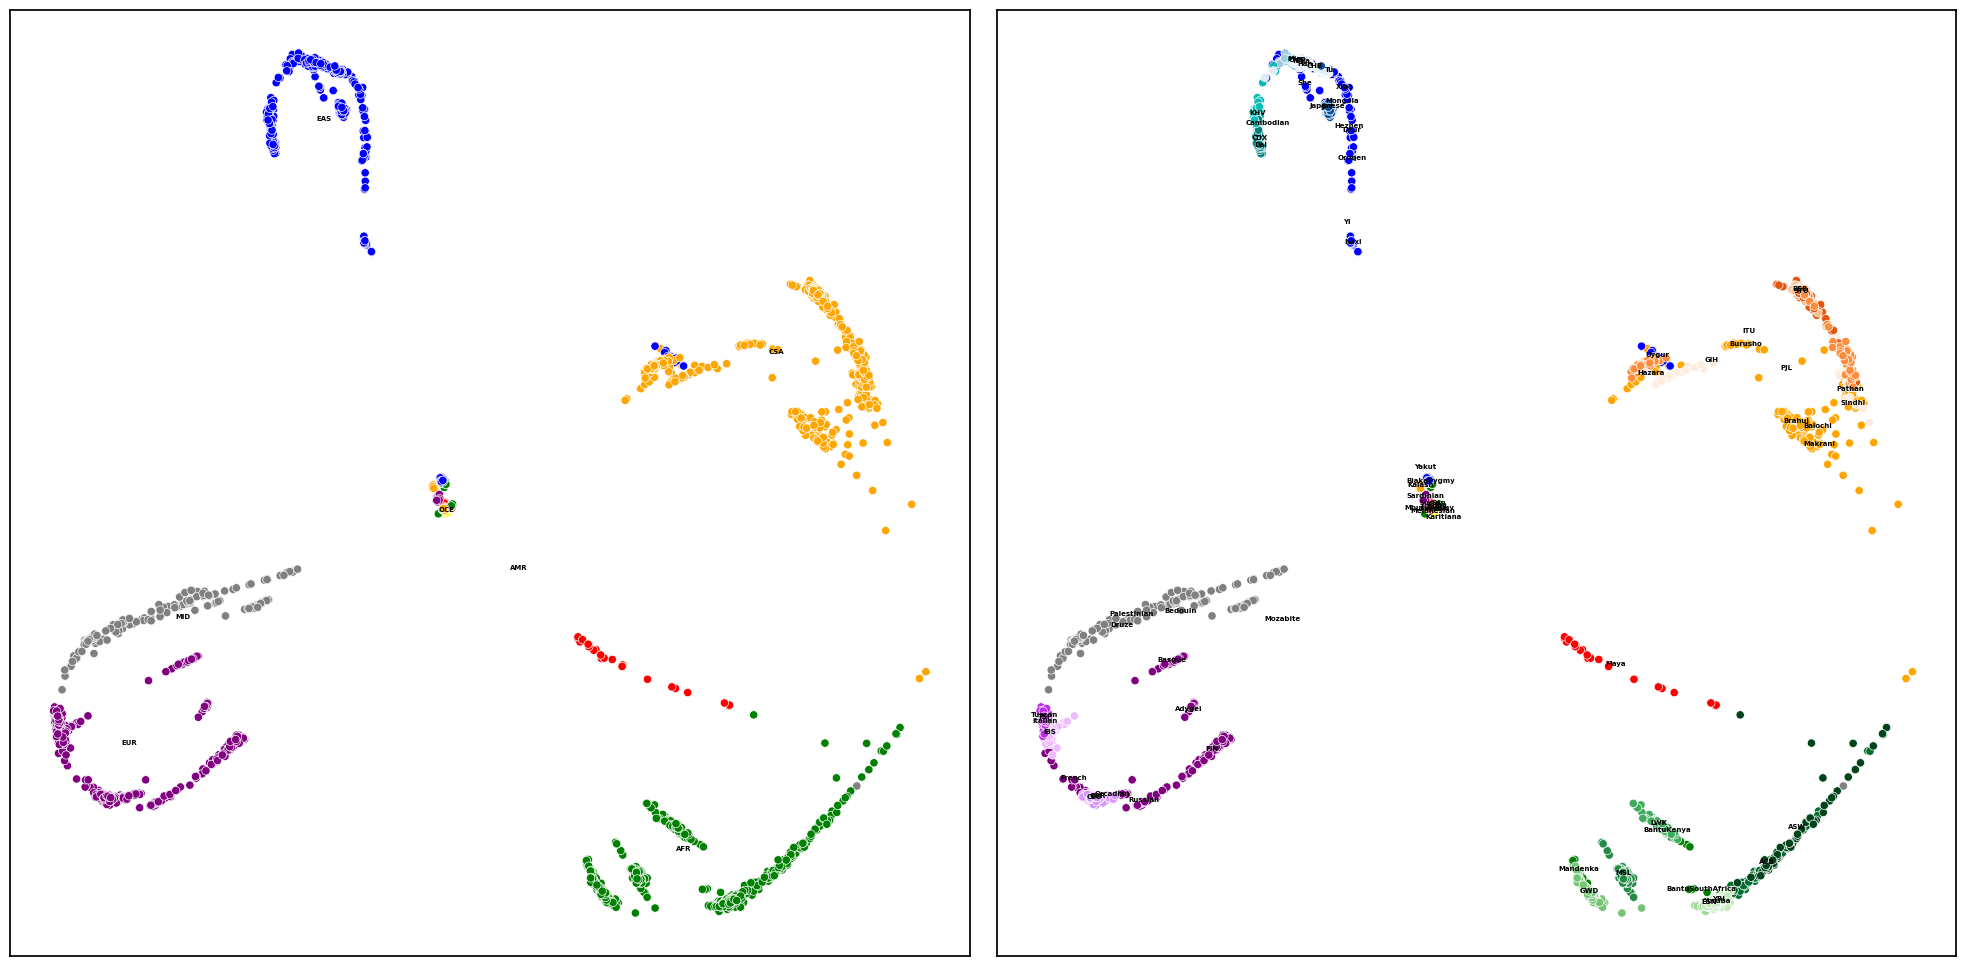

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Superpopulation'].values[idx_to_keep], 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse,
                         True,
                         ax[0])
plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Population'].values[idx_to_keep], 
                         None,
                         pop_palette_hgdp_fine_noadmixAMR,
                         label_order_hgdp_fine_noadmixAMR,
                         True,
                         ax[1])
plt.tight_layout()

## Balanced Populations

In [15]:
idx_to_keep = []
for pop in metadata_labels['Population'].unique():
    pop_sample_id = metadata_labels[metadata_labels['Population'] == pop].index
    if len(pop_sample_id) < 20:
        idx_to_keep += pop_sample_id.tolist()
    else:
        r_ids = np.random.choice(pop_sample_id, 20, replace=False)
        idx_to_keep += r_ids.tolist()
idx_to_keep = (metadata_labels.index.isin(idx_to_keep))

In [23]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs[idx_to_keep])

In [24]:
phate_operator = phate.PHATE(random_state=42, knn=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

Running PHATE on 1286 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.21 seconds.
  Calculating affinities...
  Calculated affinities in 0.08 seconds.
Calculated graph and diffusion operator in 0.30 seconds.
Calculating optimal t...
  Automatically selected t = 52
Calculated optimal t in 0.78 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.66 seconds.
Calculating metric MDS...
Calculated metric MDS in 1.39 seconds.


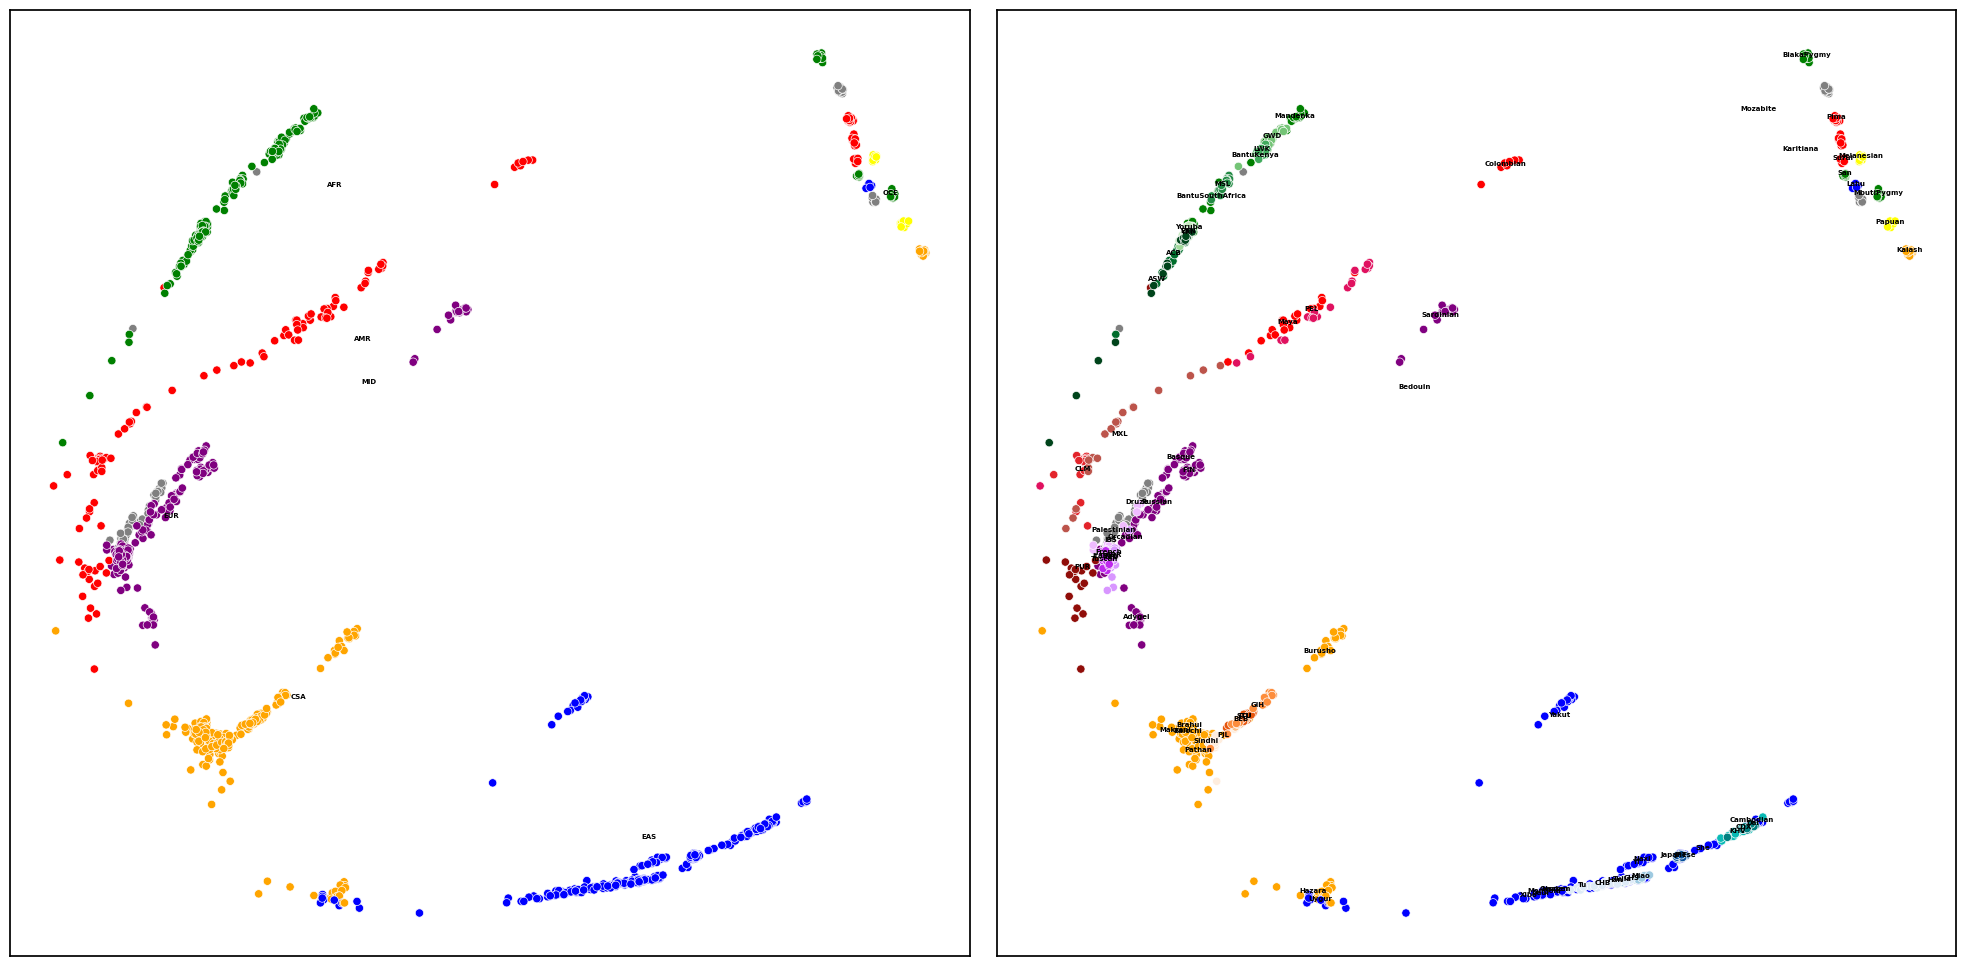

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Superpopulation'].values[idx_to_keep], 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse,
                         True,
                         ax[0])
plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Population'].values[idx_to_keep], 
                         None,
                         pop_palette_hgdp_fine,
                         label_order_hgdp_fine,
                         True,
                         ax[1])
plt.tight_layout()

In [26]:
# Now transform the rest
pca_input = pca_obj.transform(inputs)

In [27]:
phate_operator = phate.PHATE(random_state=42, knn=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.78 seconds.
  Calculating affinities...
  Calculated affinities in 0.33 seconds.
Calculated graph and diffusion operator in 1.12 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.28 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.34 seconds.
Calculated landmark operator in 2.27 seconds.
Calculating optimal t...
  Automatically selected t = 26
Calculated optimal t in 2.60 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.69 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.62 seconds.


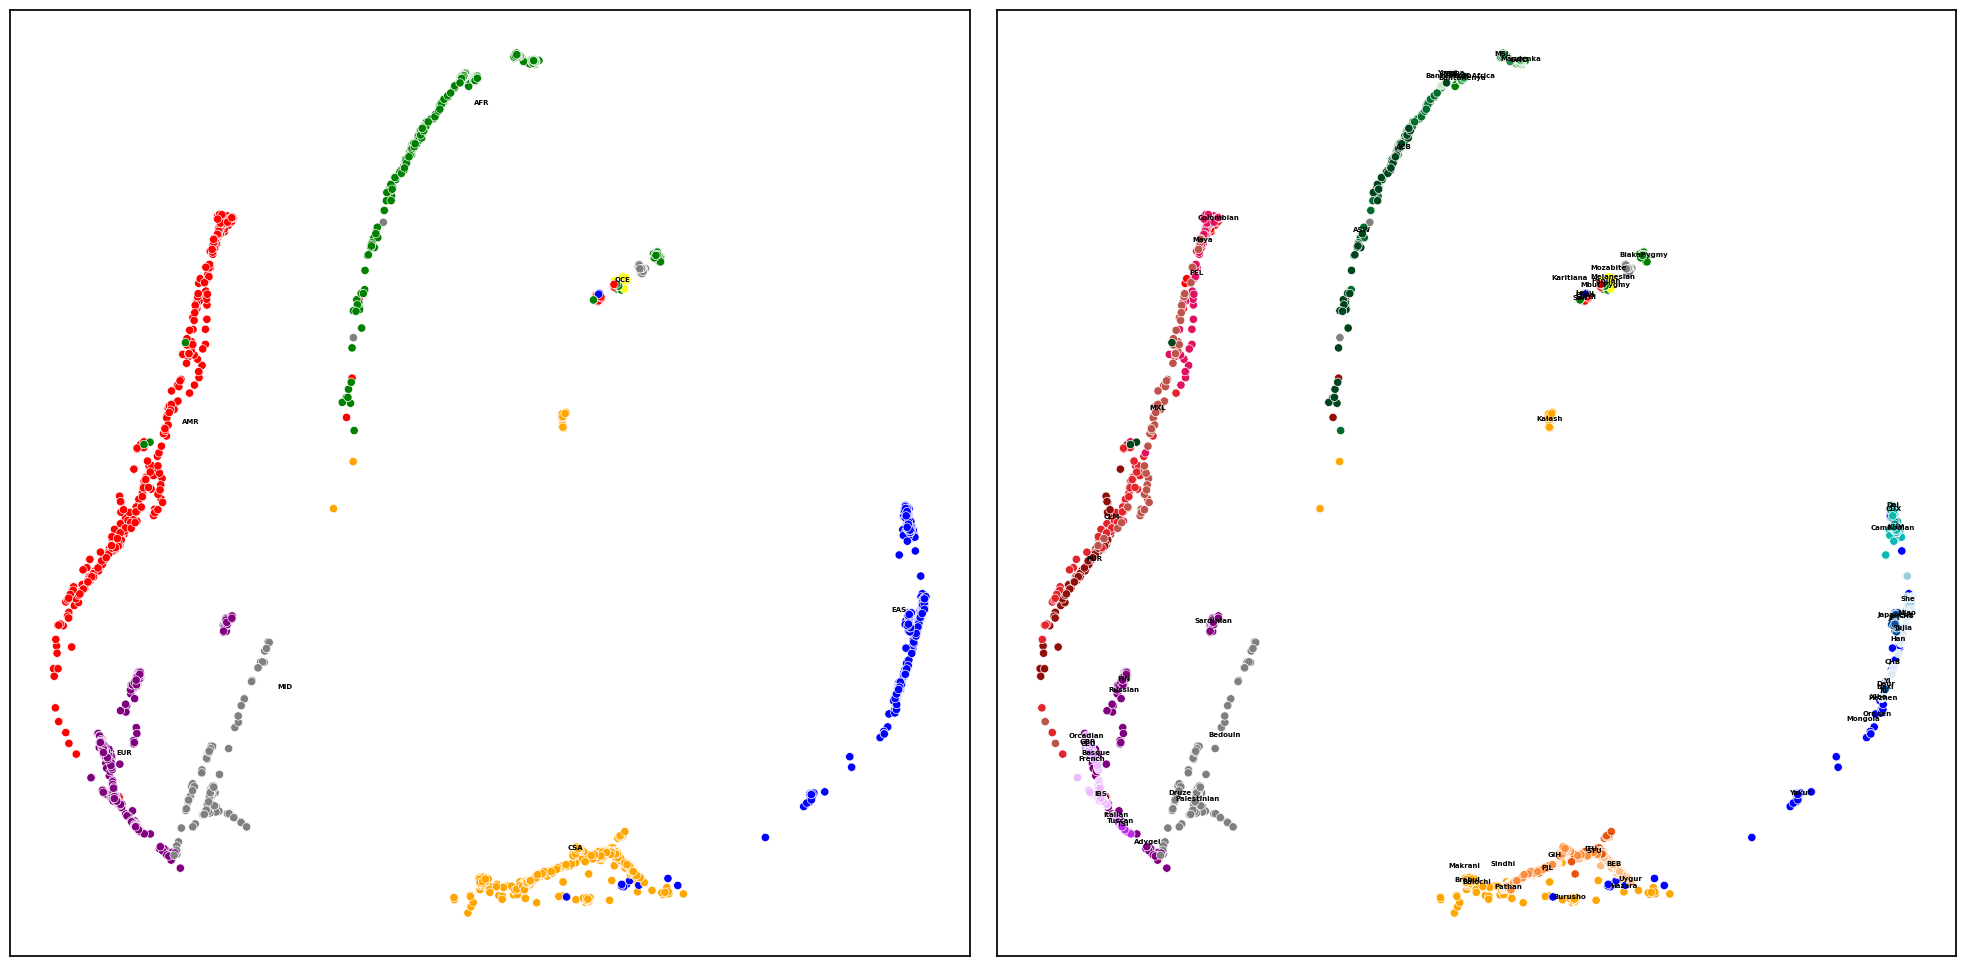

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Superpopulation'].values, 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse,
                         True,
                         ax[0])
plotting.plot_embeddings(phate_emb, 
                         metadata_labels['Population'].values, 
                         None,
                         pop_palette_hgdp_fine,
                         label_order_hgdp_fine,
                         True,
                         ax[1])
plt.tight_layout()